In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as dates

#mySEIR = SEIR(df)
#mySEIR.predict("data", ["totale_casi","totale_ospedalizzati","deceduti","ricoverati_con_sintomi"])
#mySEIR.plot()
class SEIR:
    def __init__(self, df):
        self.df = df
    def predict(self, datetimeCol, valueCols):
        self.valueCols = valueCols
        self.X = {}
        self.y = {}
        self.X_pred = {}
        self.y_pred = {}
        self.dailyCoeff = {}
        # two column: datetime [datetime64[ns]], value [int64]
        for valueCol in self.valueCols:
            # Delete <=0 values (because of log)
            df = self.df[self.df[valueCol]>0].copy()
            df = df.groupby([datetimeCol]).agg({valueCol:"sum"}).reset_index()
            df["yLog"] = np.log(df[valueCol])
            # Extract time
            self.X[valueCol] = df[[datetimeCol]]
            # Convert to int
            X_int = self.X[valueCol].copy().astype(int)
            ## for backwards conversion to datetime: pd.to_datetime(X[datetimeCol].astype(int))
            self.y[valueCol] = df[valueCol]
            y_log = df["yLog"]
            # Create model
            regressor = LinearRegression()
            model = regressor.fit(X_int, y_log)
            r_sq = model.score(X_int, y_log)
            coeff = regressor.coef_[0]
            # Factor of daily evolution
            self.dailyCoeff[valueCol] = round(10**(3600*24*(10**9)*regressor.coef_[0]), 1)
            print(self.dailyCoeff[valueCol])
            #print('intercept:', model.intercept_)
            #print('slope:', model.coef_[0])

            # Generate prediction: regressor.predict(convertedX)
            self.X_pred[valueCol] = pd.DataFrame([
                self.X[valueCol].min(), 
                self.X[valueCol].min() + pd.Timedelta(1, unit='d'), 
                self.X[valueCol].max() + pd.Timedelta(14, unit='d')])
            self.y_pred[valueCol] = np.exp(regressor.predict(self.X_pred[valueCol].astype(int)))
    def plot(self):
        # Plot result
        fig, ax = plt.subplots(ncols=1, nrows=1)
        ax.set_yscale("log")
        #ax.set_ylim(1,10000)

        ax.grid(True, which="minor", axis="y", color='g', linestyle='--', linewidth=1)
        ax.grid(True, which="major", axis="y", color='g', linestyle='-', linewidth=2)

        ax.xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
        ax.grid(True, which="major", axis="x", color='g', linestyle='-', linewidth=2)
        fig.set_size_inches(20,10)
        for valueCol in self.valueCols:
            plotDf = pd.DataFrame(self.X[valueCol])
            plotDf["y"]=self.y[valueCol]
            plotDf.columns = ["date","y"]
            plotDf.plot(x="date", y="y", ax=ax, style="o:", label="act "+valueCol)

            plotDf_pred = pd.DataFrame(self.X_pred[valueCol])
            plotDf_pred["y"]=self.y_pred[valueCol]
            plotDf_pred.columns = ["date","y"]
            plotDf_pred.plot(x="date", y="y", ax=ax, style="--", label="pred "+valueCol)
        plt.title('prediction')
        plt.xlabel('datetime')
        plt.ylabel('yLabel')
        plt.show()

In [2]:
import requests
import io

# Load data from url
def loadData(url):
    urlData = requests.get(url).content
    return pd.read_csv(io.StringIO(urlData.decode('utf-8')))
# Pivoting
def Pivot(df):
    # Exclude outside Europe
    df = df[
        (df["Lat"]>40) & (df["Lat"]<55)
        & (df["Long"]>0) & (df["Long"]<27)
    ]
    df = df.set_index(["Province/State", "Country/Region","Lat","Long"])
    df = df.stack().reset_index().rename(
        columns={"level_4":"Date",0:"Value"}
    )
    df["update"] = pd.to_datetime(df["Date"])
    maxDate = df["update"].max()
    df = df[
        (df["update"]>maxDate - pd.Timedelta(days=60))
    ]
    return df[df["Value"]>0][["Country/Region","update","Value"]]

# Configuration and load of base data

In [3]:
base_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmedUrl = "time_series_19-covid-Confirmed.csv"
deathsUrl = "time_series_19-covid-Deaths.csv"
recoveredUrl = "time_series_19-covid-Recovered.csv"

countriesSelected = ["Italy","France","Germany"]

In [4]:
confirmedDf = loadData(base_url+confirmedUrl)
deathsDf = loadData(base_url+deathsUrl)
recoveredDf = loadData(base_url+recoveredUrl)

# Start of Analysis

In [11]:
pivotDf_confirmed = Pivot(confirmedDf).groupby(["Country/Region","update"]).agg({"Value":"sum"})
pivotDf_confirmed.columns = ["confirmed_cases"]

pivotDf_deaths = Pivot(deathsDf).groupby(["Country/Region","update"]).agg({"Value":"sum"})
pivotDf_deaths.columns = ["deaths"]

pivotDf_recovered = Pivot(recoveredDf).groupby(["Country/Region","update"]).agg({"Value":"sum"})
pivotDf_recovered.columns = ["recovered_cases"]

In [12]:
pivotDf = pivotDf_confirmed.join(pivotDf_deaths)
pivotDf = pivotDf.join(pivotDf_recovered)
pivotDf = pivotDf.fillna(0).reset_index()
pivotDf.head()

,Country/Region,update,confirmed_cases,deaths,recovered_cases
0,Albania,2020-03-09,2,0.0,0.0
1,Albania,2020-03-10,10,0.0,0.0
2,Albania,2020-03-11,12,1.0,0.0
3,Albania,2020-03-12,23,1.0,0.0
4,Albania,2020-03-13,33,1.0,0.0


1.8
2.0
1.9


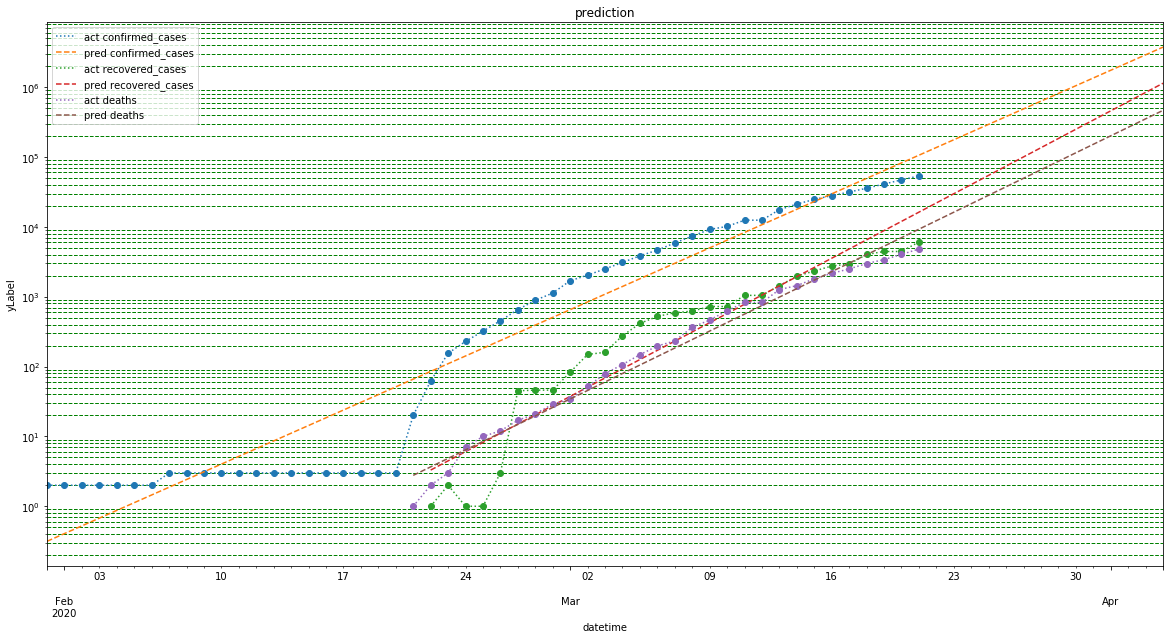

In [13]:
mySEIR = SEIR(pivotDf[pivotDf["Country/Region"]=="Italy"])
mySEIR.predict("update", ["confirmed_cases","recovered_cases","deaths"])
mySEIR.plot()

In [20]:
mySEIR.X["confirmed_cases"].head()
mySEIR.X_pred["confirmed_cases"].head()
mySEIR.y["confirmed_cases"]
mySEIR.y_pred["confirmed_cases"]

array([3.15144320e-01, 4.06491936e-01, 3.74305546e+06])